In [1]:
#JUST SETTING UP JUPYTER NOTEBOOK PREFERENCES
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    value.__cause__ = None  # suppress chained exceptions
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

In [2]:
from blocks import residual_block, residual_block_id
from augment import preprocess_fn

import glob
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import cv2
import keras
from PIL import Image
import keras.backend as K
import tensorflow as tf

In [3]:
#directly into memory, load image paths, plus 84 (x,y) keypoints == 168 annotations
#actual images lazy loaded  with Tensorflow Dataset
key_pts_frame = pd.read_csv('/data/training_frames_keypoints.csv')
#reorder so image paths match os.walk order
key_pts_frame = key_pts_frame.sort_values(by='Unnamed: 0')
key_pts = key_pts_frame.iloc[:, 1:].values
key_pts = key_pts.reshape(-1,68,2)
key_pts_frame.head()

,Unnamed: 0,0,1,2,3,4,5,6,7,8,...,126,127,128,129,130,131,132,133,134,135
2126,Abdel_Aziz_Al-Hakim_00.jpg,65.0,109.0,69.0,131.0,73.0,149.0,82.0,162.0,96.0,...,180.0,155.0,193.0,155.0,180.0,164.0,171.0,164.0,162.0,163.0
2006,Abdel_Aziz_Al-Hakim_01.jpg,74.0,103.0,78.0,125.0,83.0,143.0,91.0,157.0,100.0,...,184.0,149.0,197.0,149.0,184.0,154.0,175.0,158.0,166.0,158.0
1416,Abdel_Aziz_Al-Hakim_02.jpg,79.0,94.0,83.0,112.0,88.0,134.0,97.0,148.0,106.0,...,185.0,140.0,198.0,141.0,190.0,149.0,181.0,149.0,172.0,149.0
3324,Abdel_Aziz_Al-Hakim_10.jpg,65.0,111.0,68.0,123.0,71.0,132.0,74.0,142.0,80.0,...,105.0,139.0,120.0,136.0,105.0,139.0,102.0,142.0,95.0,142.0
2703,Abdel_Aziz_Al-Hakim_11.jpg,89.0,95.0,86.0,107.0,86.0,116.0,86.0,128.0,86.0,...,119.0,129.0,128.0,132.0,116.0,132.0,113.0,132.0,110.0,129.0


In [4]:
n_instances = key_pts_frame.shape[0]
#get list of image paths
img_paths = key_pts_frame.iloc[:,0].values
#collect original image size data to stretch label coords at same ratio as stretching images
orig_sizes = np.empty(n_instances,dtype=object)

for i, path in enumerate(img_paths):
    img = Image.open(os.path.join('/data/training_super/training',path))#wont actually bring images into memory
    orig_sizes[i] = img.size

In [5]:
#stretch each label coord to match the stretch of its corresponding image
STD_W = 256
STD_H = 256
STD_SIZE = (STD_W,STD_H)

for i in range(n_instances):
    resize_ratio_W = STD_W/orig_sizes[i][0]
    resize_ratio_H = STD_H/orig_sizes[i][1]
    key_pts[i][:,0] = key_pts[i][:,0]*resize_ratio_W
    key_pts[i][:,1] = key_pts[i][:,1]*resize_ratio_H

# train_label_dataset = tf.data.Dataset.from_tensor_slices(key_pts[:,np.array([40,43,31,9])-1])#four keypoints representative keypoints
train_label_dataset = tf.data.Dataset.from_tensor_slices(key_pts)

In [6]:
train_label_dataset

<TensorSliceDataset shapes: (68, 2), types: tf.float64>

In [7]:
#build image dataset

#stretching all images to intermediate size 
BATCH_SIZE = 2 #************************************LOWER FOR TESTING************************
#note that keras requires a super-directory workaround or renaming files if filenames have a certain format
#note drop remainder not available in this method
train_image_dataset = keras.preprocessing.image_dataset_from_directory(
    '/data/training_super/', label_mode=None,
    class_names=None, color_mode='rgb', batch_size=1, image_size=STD_SIZE, shuffle=False, interpolation='bicubic'
) 
train_image_dataset = train_image_dataset.unbatch()
#combine training image and label datasets
train = tf.data.Dataset.zip((train_image_dataset,train_label_dataset))

Found 3462 files belonging to 1 classes.


In [8]:
train = train.shuffle(10000).batch(BATCH_SIZE, drop_remainder=True).prefetch(tf.data.experimental.AUTOTUNE)

#20% for validation
#TODO: write helper fxns for this
valid = train.enumerate().filter(lambda x, y: x%5==0)
valid= valid.map(lambda x,y:y)

train = train.enumerate().filter(lambda x, y: x%5!=0)
train= train.map(lambda x,y:y)

In [9]:
class Preprocess(keras.layers.experimental.preprocessing.PreprocessingLayer):                      
        def call(self, inputs):
                seq = iaa.Sequential([
                        iaa.Fliplr(0.5),
                        iaa.Flipud(0.5),
                        iaa.Affine(translate_px={"x": (50, 50)}, rotate=(-10, 10)),
                        ])
                # seq = tf.py_function(func=seq, inp=[x,y], Tout=tf.float32)        
                x,y = seq(images=inputs[0].numpy(), keypoints=inputs[1].numpy())            
                return (x,y)

Preprocess()

In [10]:
#  use the python code in graph mode
train = train.unbatch().map(lambda x,y: tf.py_function(func=preprocess_fn,
      inp=[x,y], Tout=[tf.float32,tf.float32]))

In [11]:
# example = [x for x in train.take(1)]
# # example[0][1]
# for img, label in example:
#     plt.imshow(img/255.)
#     plt.scatter(label[:, 0], label[:, 1], s=20, marker='.', c='m')

In [12]:
# base_model = keras.models.load_model('/home/evan/Desktop/saved_model.h5')

In [13]:
from tensorflow.keras.layers import DepthwiseConv2D, Conv2D, MaxPool2D, Convolution2DTranspose
from tensorflow.keras.layers import ZeroPadding2D, Reshape, ReLU, Add, Concatenate
from tensorflow.keras import Model, Input

inputs = Input(shape=(256,256,3), name="img")
print(inputs)
conv_1  = Conv2D(32,3,strides=(2,2),use_bias=True,padding='same',name="conv_1")(inputs)
relu_1  = ReLU()(conv_1)
print(relu_1)

residualb_1 = residual_block(relu_1, 32,"residualb_1")
residualb_2 = residual_block(residualb_1, 32,"residualb_2")
residualb_3 = residual_block(residualb_2, 32,"residualb_3")
residualb_4 = residual_block(residualb_3, 32,"residualb_4")
residualb_5 = residual_block(residualb_4, 32,"residualb_5")
residualb_6 = residual_block(residualb_5, 32,"residualb_6")
residualb_7 = residual_block(residualb_6, 32,"residualb_7") 

residualb_8 = residual_block_id(residualb_7, 64,"residualb_8")

residualb_9 = residual_block(residualb_8, 64,"residualb_9")
residualb_10 = residual_block(residualb_9, 64,"residualb_10")
residualb_11 = residual_block(residualb_10, 64,"residualb_11")
residualb_12 = residual_block(residualb_11, 64,"residualb_12")
residualb_13 = residual_block(residualb_12, 64,"residualb_13")
residualb_14 = residual_block(residualb_13, 64,"residualb_14")
residualb_15 = residual_block(residualb_14, 64,"residualb_15")

residualb_16 = residual_block_id(residualb_15, 128,"residualb_16")

residualb_17 = residual_block(residualb_16, 128,"residualb_17")
residualb_18 = residual_block(residualb_17, 128,"residualb_18")
residualb_19 = residual_block(residualb_18, 128,"residualb_19")
residualb_20 = residual_block(residualb_19, 128,"residualb_20")
residualb_21 = residual_block(residualb_20, 128,"residualb_21")
residualb_22 = residual_block(residualb_21, 128,"residualb_22")
residualb_23 = residual_block(residualb_22, 128,"residualb_23")

residualb_24 = residual_block_id(residualb_23, 256,"residualb_24")

residualb_25 = residual_block(residualb_24, 256,"residualb_25")
residualb_26 = residual_block(residualb_25, 256,"residualb_26")
residualb_27 = residual_block(residualb_26, 256,"residualb_27")
residualb_28 = residual_block(residualb_27, 256,"residualb_28")
residualb_29 = residual_block(residualb_28, 256,"residualb_29")
residualb_30 = residual_block(residualb_29, 256,"residualb_30")
residualb_31 = residual_block(residualb_30, 256,"residualb_31")

max_pool_1   = MaxPool2D(pool_size=(3,3),strides=(2,2),padding='same')(residualb_31)
dconv_1      = DepthwiseConv2D(kernel_size=(3,3),strides=(2,2),padding='same',name="dconv_1")(residualb_31)
conv_2       = Conv2D(filters=256,kernel_size=(1,1),strides=(1,1),padding='valid',name="conv_2")(dconv_1)

add_1        = Add()([conv_2, max_pool_1])
relu_2       = ReLU()(add_1)

residualb_32 = residual_block(relu_2,256,"residualb_32")
residualb_33 = residual_block(residualb_32,256,"residualb_33")
residualb_34 = residual_block(residualb_33,256,"residualb_34")
residualb_35 = residual_block(residualb_34,256,"residualb_35")
residualb_36 = residual_block(residualb_35,256,"residualb_36")
residualb_37 = residual_block(residualb_36,256,"residualb_37")

#split key
residualb_38 = residual_block(residualb_37,256,"residualb_38")

#BRANCH 1
conv_transpose_1 = Convolution2DTranspose(filters=256, kernel_size=(2,2), strides=(2,2),name="convt_1")(residualb_38)
relu_3         = ReLU()(conv_transpose_1)
add_2          = Add()([residualb_31,relu_3])
#split key
residualb_39 = residual_block(add_2,256,"residualb_39")

conv_transpose_2 = Convolution2DTranspose(filters=128,kernel_size=(2,2),strides=(2,2),name="convt_2")(residualb_39)
relu_4     = ReLU()(conv_transpose_2)
add_3      = Add()([residualb_23,relu_4])
#split key
residualb_40 = residual_block(add_3,128,"residualb_40")


# output block 1
conv_3 = Conv2D(filters=2,kernel_size=(1,1),strides=(1,1),padding='same',name="conv_3")(residualb_40)
#reshape_1 = tf.reshape(conv_3,[1,2048,1])
reshape_1 = Reshape([-1,1])(conv_3)

conv_4 = Conv2D(filters=2,kernel_size=(1,1),strides=(1,1),name="conv_4")(residualb_39)
#reshape_2 = tf.reshape(conv_4,[1,512,1])
reshape_2 = Reshape([-1,1])(conv_4)

conv_5 = Conv2D(filters=6,kernel_size=(1,1),strides=(1,1),name="conv_5")(residualb_38)
#reshape_3 = tf.reshape(conv_5, [1,384,1])
reshape_3 = Reshape([-1,1])(conv_5)

base_output = reshape_3

KerasTensor(type_spec=TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name='img'), name='img', description="created by layer 'img'")
KerasTensor(type_spec=TensorSpec(shape=(None, 128, 128, 32), dtype=tf.float32, name=None), name='re_lu/Relu:0', description="created by layer 're_lu'")


In [14]:
base_output

<KerasTensor: shape=(None, 384, 1) dtype=float32 (created by layer 'reshape_2')>

In [15]:
Z = base_output

Z = keras.layers.Reshape([-1])(Z)
Z = keras.layers.Dense(136,activation='sigmoid')(Z)#
Z = keras.layers.Lambda(lambda x: x*255.)(Z)
Z = keras.layers.Reshape([68,2])(Z)

# Z = keras.layers.Lambda(lambda x: nms(s))#non maximum supression


model= tf.keras.Model(inputs=inputs, outputs=Z)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 128, 128, 32) 896         img[0][0]                        
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 128, 128, 32) 0           conv_1[0][0]                     
__________________________________________________________________________________________________
residualb_1/dconv (DepthwiseCon (None, 128, 128, 32) 320         re_lu[0][0]                      
______________________________________________________________________________________________

In [16]:
train = train.repeat(int(1e10))

In [17]:
K.clear_session()
root_logdir = os.path.join(os.curdir, "keypoint_logs")
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
print('run logged at:' ,run_logdir)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
checkpoint_cb = keras.callbacks.ModelCheckpoint('keypoint_model', save_best_only=True)
early_stop_cb = keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)



optimizer = keras.optimizers.Nadam(lr=0.001)

model.compile(loss='mse', optimizer=optimizer)

run logged at: ./keypoint_logs/run_2021_01_23-15_32_15


In [18]:
# for layer in base_model.layers:
#     layer.trainable = False

In [19]:

# model= keras.models.load_model('/home/evan/Desktop/my_model') #USE IF WANT TO RELOAD OLD MODEL
model.fit(train.batch(2),epochs=5,steps_per_epoch=500, callbacks = [tensorboard_cb, checkpoint_cb,early_stop_cb])#validation_data = valid

Epoch 1/5
 17/500 [>.............................] - ETA: 2:24 - loss: 17108.4923

KeyboardInterrupt: 

In [29]:
# for layer in base_model.layers:
#     layer.trainable = True
model.fit(train.batch(2),epochs=20,steps_per_epoch=500, callbacks = [tensorboard_cb, checkpoint_cb,early_stop_cb])#validation_data = valid

Epoch 1/20
 15/500 [..............................] - ETA: 2:14 - loss: 18098.8066

KeyboardInterrupt: 

In [30]:
#WE DID IT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! :)

In [31]:
# model.evaluate(valid)

In [32]:
#DISPLAY A SAMPLE OF THE PREDICTIONS
target_images = [ x for x in valid.map(lambda x, y : x).unbatch().take(8)]
target = tf.data.Dataset.from_tensor_slices(target_images).batch(8)
preds = model.predict(target)


In [33]:
preds

array([[[  0., 255.],
        [255.,   0.],
        [  0., 255.],
        ...,
        [255.,   0.],
        [255., 255.],
        [255., 255.]],

       [[  0., 255.],
        [255.,   0.],
        [  0., 255.],
        ...,
        [255.,   0.],
        [255., 255.],
        [255., 255.]],

       [[  0., 255.],
        [255.,   0.],
        [  0., 255.],
        ...,
        [255.,   0.],
        [255., 255.],
        [255., 255.]],

       ...,

       [[  0., 255.],
        [255.,   0.],
        [  0., 255.],
        ...,
        [255.,   0.],
        [255., 255.],
        [255., 255.]],

       [[  0., 255.],
        [255.,   0.],
        [  0., 255.],
        ...,
        [255.,   0.],
        [255., 255.],
        [255., 255.]],

       [[  0., 255.],
        [255.,   0.],
        [  0., 255.],
        ...,
        [255.,   0.],
        [255., 255.],
        [255., 255.]]], dtype=float32)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


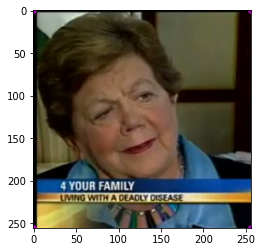

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


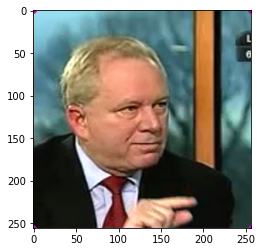

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


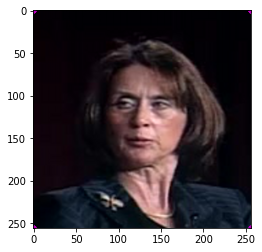

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


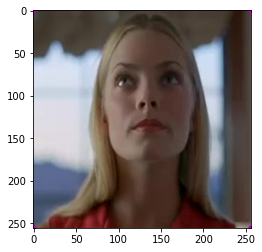

In [34]:
ixs = [0,4,6,7]
for ix in ixs:
    pred = preds[ix]
    img = target_images[ix]
    plt.imshow(img/255.)
    plt.scatter(pred[:, 0], pred[:, 1], s=20, marker='.', c='m')
    plt.show()